RND

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np, pandas as pd
import yfinance as yf
import os
from datetime import datetime, timezone, date, timedelta

from math import log, sqrt, exp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.integrate import trapezoid
import matplotlib.cm as cm
from scipy.integrate import simpson

In [ ]:
ASOF = pd.Timestamp.now(tz='UTC')

In [ ]:
!git clone https://github.com/AlexMilekhin/Volatility-Surface-Modelling-ML-Forecasting.git
import sys
sys.path.append("/content/Volatility-Surface-Modelling-ML-Forecasting")
from vol_utils import bs_price, implied_vol, infer_forward_parity

fatal: destination path 'Volatility-Surface-Modelling-ML-Forecasting' already exists and is not an empty directory.


In [ ]:
# Configuration
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/VolSurf_ML"
HIST_PRICE_PATH = os.path.join(BASE_DIR, 'hist_price.parquet')
OPTIONS_PATH = os.path.join(BASE_DIR, "cleaned_options_data.parquet")
ALL_PARQUET   = os.path.join(BASE_DIR, "combined_options_data.parquet")
SSVI_METRICS_PARQUET = os.path.join(BASE_DIR, f"metrics/ssvi_metrics_{ASOF.date()}.parquet")
SVI_METRICS_PARQUET = os.path.join(BASE_DIR, f"metrics/svi_metrics_{ASOF.date()}.parquet")
SSVI_SURFACE_PATH = os.path.join(BASE_DIR, f"surface/ssvi_surface_{ASOF.date()}.parquet")
SSVI_PARAMS_PATH = os.path.join(BASE_DIR, f"metrics/ssvi_params_{ASOF.date()}.parquet")

TT_NPY = os.path.join(BASE_DIR, "TT_grid.npy")       # time grid (years)
KK_NPY = os.path.join(BASE_DIR, "KK_grid.npy")       # k-grid (log-moneyness) OR K-grid (strikes)
IV_NPY = os.path.join(BASE_DIR, "IV_grid.npy")       # market IV grid (for comparison only)

In [ ]:
# 1. Load Market Data
print("Loading market data...")
hist_price = pd.read_parquet(HIST_PRICE_PATH)
options_all = pd.read_parquet(OPTIONS_PATH)

# Normalize Dates for Comparison (Force UTC then strip)
target_asof = pd.to_datetime(ASOF, utc=True).tz_convert(None)
target_date = target_asof.normalize()

# Handle hist_price date
if 'Date' in hist_price.columns:
    date_col = 'Date'
elif 'asof' in hist_price.columns:
    date_col = 'asof'
else:
    hist_price = hist_price.reset_index()
    date_col = hist_price.columns[0]

hist_price[date_col] = pd.to_datetime(hist_price[date_col], utc=True).dt.tz_convert(None).dt.normalize()

# Handle options_all date
if 'asof' not in options_all.columns:
    if 'Date' in options_all.columns:
        options_all.rename(columns={'Date': 'asof'}, inplace=True)
    else:
        # Create dummy asof if missing, or raise error. Here we assume we can proceed or fail gracefully.
        print("Warning: 'asof' column missing in options data. Adding dummy.")
        options_all['asof'] = target_date

options_all['asof'] = pd.to_datetime(options_all['asof'], utc=True).dt.tz_convert(None).dt.normalize()

# 2. Retrieve S0 with Fallback
price_candidates = ['close', 'Close', 'adj_close', 'Adj Close', 'underlying_price']
price_col = next((c for c in price_candidates if c in hist_price.columns), None)

if price_col:
    row_price = hist_price.loc[hist_price[date_col] == target_date]
    if row_price.empty:
        print(f"Warning: No price found for {target_date.date()}. Using latest available record.")
        row_price = hist_price.iloc[[-1]]
        print(f"  -> Using price from: {row_price[date_col].iloc[0].date()}")
    S0 = float(row_price[price_col].iloc[0])
else:
    print("Error: No price column found. Setting S0=100.0 default.")
    S0 = 100.0

rate_ticker = "^IRX"
rate_data = yf.Ticker(rate_ticker).history(period='1d')
r0 = rate_data['Close'].values*0.01

# 4. Load SSVI Parameters/Data
print("Loading SSVI Data...")
ssvi_params_df = None
using_params = False

# Try Params Path
try:
    ssvi_params_df = pd.read_parquet(SSVI_PARAMS_PATH)
    using_params = True
    print(f"Loaded params from {SSVI_PARAMS_PATH}")
except FileNotFoundError:
    # Try Metrics Path
    try:
        ssvi_params_df = pd.read_parquet(SSVI_METRICS_PARQUET)
        using_params = True
        print(f"Loaded metrics (params) from {SSVI_METRICS_PARQUET}")
    except FileNotFoundError:
        print("SSVI Parameters/Metrics file not found. Falling back to SSVI Surface.")
        using_params = False

# Extract Info
T_chosen = None
ssvi_theta = ssvi_rho = ssvi_eta = ssvi_gamma = np.nan

if using_params and ssvi_params_df is not None:
    # Ensure asof is datetime (tz-naive)
    ssvi_params_df['asof'] = pd.to_datetime(ssvi_params_df['asof'], utc=True).dt.tz_convert(None)

    # Filter
    params_slice = ssvi_params_df[ssvi_params_df['asof'].dt.date == target_date.date()]
    if params_slice.empty:
        print("Warning: No params for target date. Using latest in file.")
        params_slice = ssvi_params_df.tail(1)

    if not params_slice.empty:
        # Detect column names
        cols = params_slice.columns
        col_t = 't' if 't' in cols else ('T' if 'T' in cols else None)
        col_theta = 'theta' if 'theta' in cols else 'ssvi_theta'
        col_rho = 'rho' if 'rho' in cols else 'ssvi_rho'
        col_eta = 'eta' if 'eta' in cols else 'ssvi_eta'
        col_gamma = 'gamma' if 'gamma' in cols else ('ssvi_gamma' if 'ssvi_gamma' in cols else 'ssvi_p')

        if col_t:
            T_chosen = float(params_slice[col_t].min())
            p_row = params_slice[params_slice[col_t] == T_chosen].iloc[0]

            ssvi_theta = float(p_row.get(col_theta, np.nan))
            ssvi_rho = float(p_row.get(col_rho, np.nan))
            ssvi_eta = float(p_row.get(col_eta, np.nan))
            ssvi_gamma = float(p_row.get(col_gamma, np.nan))
            print(f"Loaded SSVI Params for T={T_chosen}: theta={ssvi_theta}, rho={ssvi_rho}, eta={ssvi_eta}, gamma={ssvi_gamma}")
        else:
            print("Error: Could not find 't' or 'T' column in params.")

if T_chosen is None:
    # Fallback to Surface
    if os.path.exists(SSVI_SURFACE_PATH):
        surface_df = pd.read_parquet(SSVI_SURFACE_PATH)
        surface_df['asof'] = pd.to_datetime(surface_df['asof'], utc=True).dt.tz_convert(None)
        # Filter for latest date if target missing
        if not surface_df[surface_df['asof'].dt.date == target_date.date()].empty:
            surf_slice = surface_df[surface_df['asof'].dt.date == target_date.date()]
        else:
             surf_slice = surface_df[surface_df['asof'] == surface_df['asof'].max()]

        # Check column for T
        col_t_surf = 't' if 't' in surf_slice.columns else 'T'
        T_chosen = float(surf_slice[col_t_surf].min())
        print(f"Selected T={T_chosen} from Surface Data.")
    else:
        # Last resort: use df_asof if in locals
        if 'df_asof' in locals():
            print("Using 'df_asof' from memory.")
            col_t_local = 't' if 't' in locals()['df_asof'].columns else 'T'
            T_chosen = float(locals()['df_asof'][col_t_local].min())
        else:
            print("Error: No SSVI data found. Setting T=0.1 default.")
            T_chosen = 0.1

print("-" * 40)
print(f"Initialized Market Data for {target_date.date()}:")
print(f"  S0: {S0:.4f}")
print(f"  r0: {r0}")
print(f"  T:  {T_chosen:.4f}")
if using_params and not np.isnan(ssvi_theta):
    print("SSVI Parameters:")
    print(f"  theta: {ssvi_theta:.4f}")
    print(f"  rho:   {ssvi_rho:.4f}")
    print(f"  eta:   {ssvi_eta:.4f}")
    print(f"  gamma: {ssvi_gamma:.4f}")
else:
    print("SSVI Parameters: Not loaded (Using Surface Grid Fallback/Defaults)")
print("-" * 40)

Loading market data...
  -> Using price from: 2025-12-08
Loading SSVI Data...
Loaded metrics (params) from /content/drive/MyDrive/Colab Notebooks/VolSurf_ML/metrics/ssvi_metrics_2025-12-09.parquet
Loaded SSVI Params for T=0.10403832991101986: theta=0.043449415158698906, rho=0.999, eta=0.2642826731752019, gamma=0.001
----------------------------------------
Initialized Market Data for 2025-12-09:
  S0: 624.2800
  r0: [0.03618]
  T:  0.1040
SSVI Parameters:
  theta: 0.0434
  rho:   0.9990
  eta:   0.2643
  gamma: 0.0010
----------------------------------------


In [ ]:
# --- 1. Define Helper Functions (Redefined for safety) ---
def ssvi_power_law(k, theta, rho, eta, gamma):
    """Calculate total implied variance w(k) using Power-Law SSVI."""
    # phi(theta) = eta / (theta^gamma)
    phi = eta / (theta ** gamma)
    z = phi * k
    # w(k) = (theta/2) * { 1 + rho*z + sqrt( (z + rho)^2 + (1 - rho^2) ) }
    w = (theta / 2) * (1 + rho * z + np.sqrt((z + rho)**2 + (1 - rho**2)))
    return w

def bs_call_price(S, K, T, r, sigma):
    """Vectorized Black-Scholes Call Price."""
    # Avoid division by zero
    sigma = np.maximum(sigma, 1e-6)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price


Processing 15 slices...
Successfully processed 15 slices.
Saved RND Features to: /content/drive/MyDrive/Colab Notebooks/VolSurf_ML/metrics/rnd_features_2025-12-09.parquet


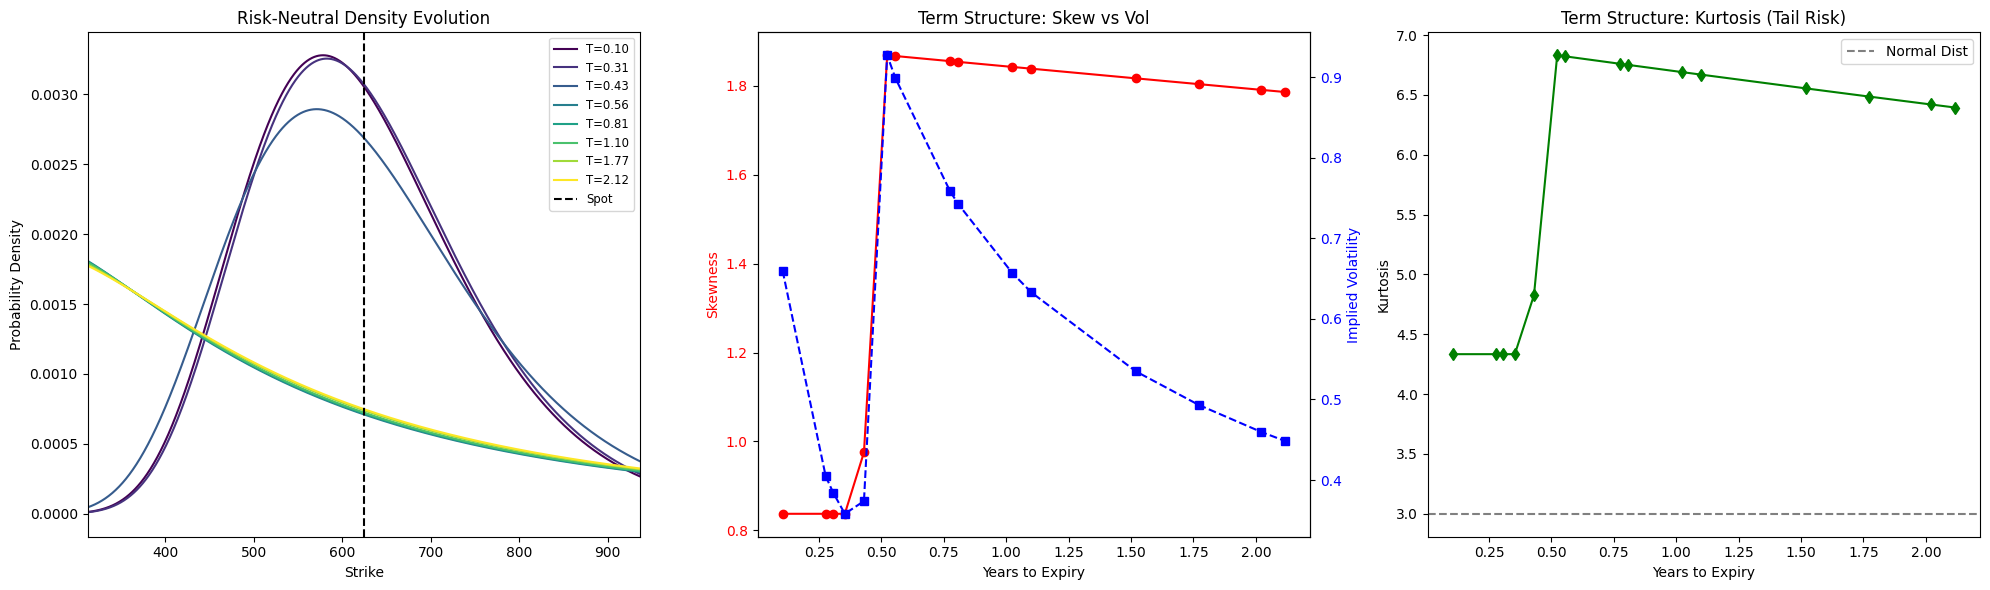


--- Martingale Quality Check (Mean vs Forward) ---
          T                    F    rnd_mean          martingale_error
0  0.104038  [626.6343141152398]  626.634308   [9.306881872278525e-09]
1  0.276523  [630.5570482486254]  630.557042  [1.0539366028081185e-08]
2  0.306639  [631.2444838794379]  631.244477  [1.0774108321880702e-08]
3  0.353183   [632.308358806653]  632.308352  [1.1133502224051493e-08]
4  0.429843  [634.0645334585469]  634.064172   [5.696272341498227e-07]


In [ ]:
# --- Configuration for Grid ---
# We use a wide grid (0.1*Spot to 4.0*Spot) to ensure we capture the full tail
# probability mass, otherwise Kurtosis calculations will be unstable.
K_MIN_MULT = 0.1
K_MAX_MULT = 4.0
N_POINTS = 5000

def process_expiry_slice(row, S0, r0):
    """
    Takes an SSVI parameter row, reconstructs the surface,
    and computes RND moments via Breeden-Litzenberger.
    """
    T = row['T']
    if T < 0.005: return None # Skip very short expiries (<2 days)

    # 1. Setup Grid
    F = S0 * np.exp(r0 * T)
    K_grid = np.linspace(S0 * K_MIN_MULT, S0 * K_MAX_MULT, N_POINTS)
    h = K_grid[1] - K_grid[0]

    # 2. Reconstruct SSVI Volatility
    # Map DataFrame columns to function args
    # Note: 'ssvi_p' in params file maps to 'gamma' in formula
    log_moneyness = np.log(K_grid / F)

    theta = row['theta']
    rho = row['ssvi_rho']
    eta = row['ssvi_eta']
    gamma = row['ssvi_p']

    # Calculate Variance w(k)
    w_grid = ssvi_power_law(log_moneyness, theta, rho, eta, gamma)
    sigma_grid = np.sqrt(np.maximum(1e-9, w_grid) / T)

    # 3. Calculate Call Prices
    # We use the imported/defined bs_price function
    calls = bs_call_price(S0, K_grid, T, r0, sigma_grid)

    # 4. Breeden-Litzenberger (2nd Derivative)
    # f(K) = e^(rT) * d2C/dK2
    d2C = (calls[2:] - 2*calls[1:-1] + calls[:-2]) / (h**2)
    f_grid = np.exp(r0 * T) * d2C

    # Align K_grid to derivative shape (lose 2 points)
    K_pdf = K_grid[1:-1]

    # Clean noise (negative density is impossible in static-arb free SVI, but numerical noise exists)
    f_grid = np.maximum(0, f_grid)

    # 5. Compute Moments (Integration)
    # Normalize first to handle slight grid leakage
    total_prob = simpson(y=f_grid, x=K_pdf)
    if total_prob < 0.95:
        return None # Grid likely too narrow for this expiry

    pdf = f_grid / total_prob

    # Mean (Martingale Check)
    mean_rn = simpson(y=K_pdf * pdf, x=K_pdf)
    martingale_error = abs(mean_rn - F) / F

    # Variance -> Vol
    var_rn = simpson(y=((K_pdf - mean_rn)**2) * pdf, x=K_pdf)
    vol_rn = np.sqrt(var_rn)

    # Skewness
    skew_rn = simpson(y=((K_pdf - mean_rn)**3) * pdf, x=K_pdf) / (vol_rn**3)

    # Kurtosis
    kurt_rn = simpson(y=((K_pdf - mean_rn)**4) * pdf, x=K_pdf) / (vol_rn**4)

    return {
        'expiry': row['expiry'],
        'T': T,
        'F': F,
        'rnd_mean': mean_rn,
        'martingale_error': martingale_error,
        'rnd_vol': np.sqrt(simpson(y=((K_pdf / F - 1.0)**2)* pdf, x=K_pdf) / T),
        'rnd_skew': skew_rn,
        'rnd_kurtosis': kurt_rn,
        'pdf_data': (K_pdf, pdf) # Store for plotting (optional)
    }

# --- Execution Loop ---
print(f"Processing {len(ssvi_params_df)} slices...")
rnd_results = []

for idx, row in ssvi_params_df.iterrows():
    res = process_expiry_slice(row, S0, r0)
    if res:
        rnd_results.append(res)

# Create DataFrame
rnd_df = pd.DataFrame([{k:v for k,v in r.items() if k != 'pdf_data'} for r in rnd_results])
print(f"Successfully processed {len(rnd_df)} slices.")

# --- Save Results ---
output_path = os.path.join(BASE_DIR, f"metrics/rnd_features_{target_date.date()}.parquet")
rnd_df.to_parquet(output_path)
print(f"Saved RND Features to: {output_path}")

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. RND Evolution (PDFs)
# Plot every 2nd slice to avoid clutter
colors = cm.viridis(np.linspace(0, 1, len(rnd_results)))
for i, res in enumerate(rnd_results):
    if i % 2 == 0:
        K, pdf = res['pdf_data']
        axes[0].plot(K, pdf, color=colors[i], label=f"T={res['T']:.2f}")
axes[0].axvline(S0, color='black', linestyle='--', label='Spot')
axes[0].set_title('Risk-Neutral Density Evolution')
axes[0].set_xlabel('Strike')
axes[0].set_ylabel('Probability Density')
axes[0].set_xlim(S0*0.5, S0*1.5) # Zoom in on the main body
axes[0].legend(fontsize='small')

# 2. Term Structure of Vol & Skew
ax2 = axes[1]
ax2.plot(rnd_df['T'], rnd_df['rnd_skew'], 'r-o', label='Skew')
ax2.set_xlabel('Years to Expiry')
ax2.set_ylabel('Skewness', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title('Term Structure: Skew vs Vol')

ax2b = ax2.twinx()
ax2b.plot(rnd_df['T'], rnd_df['rnd_vol'], 'b--s', label='RND Vol')
ax2b.set_ylabel('Implied Volatility', color='blue')
ax2b.tick_params(axis='y', labelcolor='blue')

# 3. Term Structure of Kurtosis
axes[2].plot(rnd_df['T'], rnd_df['rnd_kurtosis'], 'g-d')
axes[2].axhline(3.0, color='gray', linestyle='--', label='Normal Dist')
axes[2].set_title('Term Structure: Kurtosis (Tail Risk)')
axes[2].set_xlabel('Years to Expiry')
axes[2].set_ylabel('Kurtosis')
axes[2].legend()

plt.tight_layout()
plt.show()

# Display Quality Check
print("\n--- Martingale Quality Check (Mean vs Forward) ---")
print(rnd_df[['T', 'F', 'rnd_mean', 'martingale_error']].head())